In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

import mne
from mne.io import read_raw_edf
from mne.decoding import CSP


from pyriemann.classification import MDM, TSclassifier
from pyriemann.estimation import Covariances

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
os.getcwd()

%matplotlib inline

/home/ambisinistra/miniconda3/envs/mne_pytorch/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ambisinistra/miniconda3/envs/mne_pytorch/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
directory = '/home/ambisinistra/workspace/EEG/RAW/edf/'

for root, dirs, files in os.walk(directory):
    print (root)
    for file in files:
        if (file.split('.')[-1] == 'edf'):
            raw = read_raw_edf(root + file, preload = True)
            break

/home/ambisinistra/workspace/EEG/RAW/edf/
Extracting EDF parameters from /home/ambisinistra/workspace/EEG/RAW/edf/Bondarenko_27_09_16_Edit Markers.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 292095  =      0.000 ...  1140.996 secs...


Effective window size : 8.000 (s)


<ipython-input-3-649b28c0284d>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  _ = raw.plot_psd()


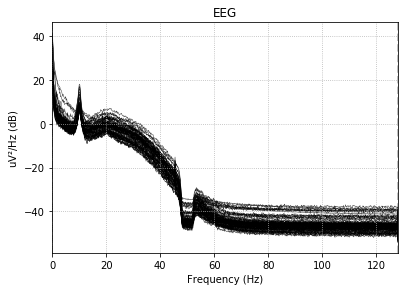

In [3]:
_ = raw.plot_psd() 
#[raw.plot_psd(picks=i) for i in raw.ch_names]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB



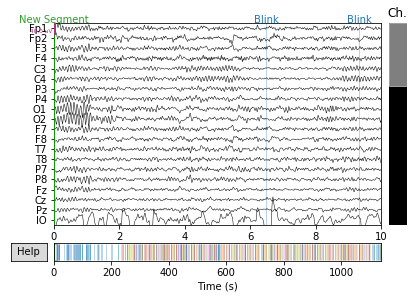

In [3]:
raw.filter(1, 20, method = "iir")
_ = raw.plot()

Effective window size : 8.000 (s)


<ipython-input-5-3a2892d888b1>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  _ = raw.plot_psd()


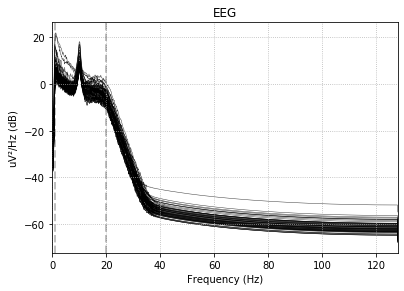

In [5]:
_ = raw.plot_psd()

In [50]:
sampling_rate = 512

decimation_factor = 10

events = mne.events_from_annotations(raw)

event_id = dict(Lie=2, Truth=9)

#TODO we can try to delete epochs with artifacts

epochs = mne.Epochs(raw, events[0], event_id, verbose=True, preload=True)

#epochs.decimate(5)

#cross validation
cv = KFold(10, shuffle=True, random_state=42)

#triyng smoothing over several epochs if needed
smoothing = 1

if smoothing != 1:
    truth = epochs["Truth"]
    new_truth = []
    new_labels = []
    for i in range(0, len(truth), smoothing):
        new_truth.append(truth[i:(i+smoothing)].average().data)
        new_labels.append(0)
    truth = np.stack(new_truth)
    lie = epochs["Lie"]
    new_lie = []
    for i in range(0, len(lie), smoothing):
        new_lie.append(lie[i:(i+smoothing)].average().data)
        new_labels.append(1)
    lie = np.stack(new_lie)
    data = np.concatenate((truth, lie), axis=0)
    labels = np.array(new_labels)
    epochs_data_train = (data - data.mean())/data.std()
else:
    epochs_data_train = (epochs.get_data() - epochs.average().data) / epochs.standard_error().data
    labels = (epochs.events[:, 2] - 2)/7 #catching events with id's 2 and 7
    
#TODO Isaichev asked to
#1 try took several epochs and average em
#2 try discard +-2 sigma

# compute covariance matrices
cov_data_train = Covariances().transform(epochs_data_train)

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
151 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 151 events and 180 original time points ...
0 bad epochs dropped


In [35]:
epochs_data_train.std()

12.288205727444506

In [27]:
tmp = epochs.get_data()

print (type(tmp), tmp.shape)

tmp = epochs.average().data #.get_data()

print (type(tmp), tmp.shape)

tmp = epochs.standard_error().data

print (type(tmp), tmp.shape)

Loading data for 151 events and 180 original time points ...
<class 'numpy.ndarray'> (151, 64, 180)
<class 'numpy.ndarray'> (64, 180)
<class 'numpy.ndarray'> (64, 180)


Loading data for 62 events and 180 original time points ...


<ipython-input-50-2134f57162e0>:1: DeprecationWarning: spatial_colors defaults to False in 0.19 but will change to True in 0.20. Set it explicitly to avoid this warning.
  _ = epochs['Lie'].plot_psd()
<ipython-input-50-2134f57162e0>:1: DeprecationWarning: average defaults to True in 0.19 but will change to False in 0.20. Set it explicitly to avoid this warning.
  _ = epochs['Lie'].plot_psd()


    Using multitaper spectrum estimation with 7 DPSS windows


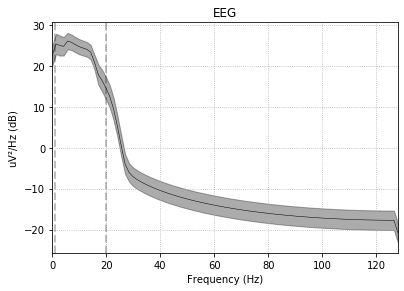

In [50]:
_ = epochs['Lie'].plot_psd()

Loading data for 89 events and 180 original time points ...


<ipython-input-51-7bdabe069449>:1: DeprecationWarning: spatial_colors defaults to False in 0.19 but will change to True in 0.20. Set it explicitly to avoid this warning.
  _ = epochs['Truth'].plot_psd()
<ipython-input-51-7bdabe069449>:1: DeprecationWarning: average defaults to True in 0.19 but will change to False in 0.20. Set it explicitly to avoid this warning.
  _ = epochs['Truth'].plot_psd()


    Using multitaper spectrum estimation with 7 DPSS windows


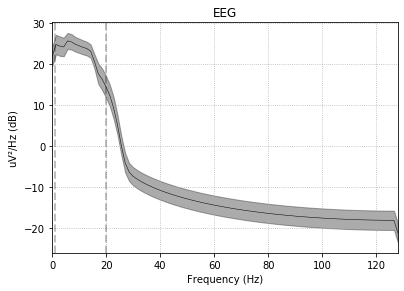

In [51]:
_ = epochs['Truth'].plot_psd()

Loading data for 5 events and 180 original time points ...
Loading data for 5 events and 180 original time points ...


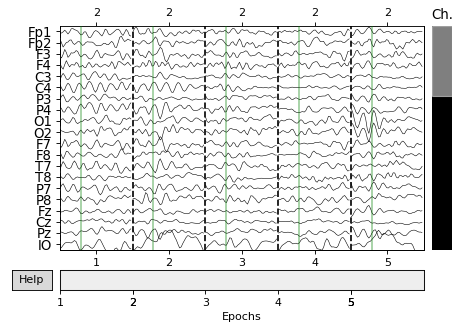

In [46]:
_ = epochs['Lie'][0:5].plot()

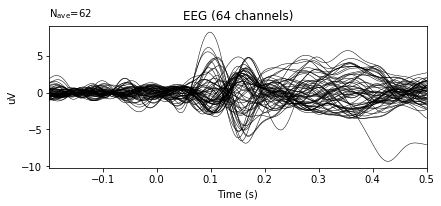

In [40]:
_ = epochs['Lie'].average().plot()

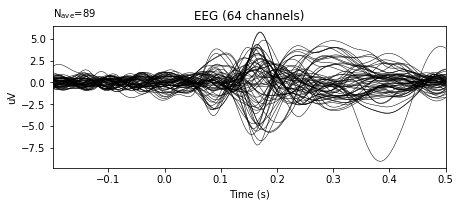

In [41]:
_ = epochs['Truth'].average().plot()

In [51]:
mdm = MDM(metric=dict(mean='riemann', distance='riemann'))

# Use scikit-learn Pipeline with cross_val_score function
scores = cross_val_score(mdm, cov_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("MDM Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                              class_balance))

MDM Classification accuracy: 0.564167 / Chance level: 0.589404


In [52]:
clf = TSclassifier()
# Use scikit-learn Pipeline with cross_val_score function
scores = cross_val_score(clf, cov_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Tangent space Classification accuracy: %f / Chance level: %f" %
      (np.mean(scores), class_balance))

Tangent space Classification accuracy: 0.570000 / Chance level: 0.589404


In [53]:
# Assemble a classifier
lr = LogisticRegression()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


clf = Pipeline([('CSP', csp), ('LogisticRegression', lr)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + LDA Classification accuracy: %f / Chance level: %f" %
      (np.mean(scores), class_balance))

Computing data rank from raw with rank=None
    Using tolerance 76 (2.2e-16 eps * 64 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing data rank from raw with rank=None
    Using tolerance 86 (2.2e-16 eps * 64 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing data rank from raw with rank=None
    Using tolerance 77 (2.2e-16 eps * 64 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing data rank from raw with rank=None
    Using tolerance 89 (2.2e-16 eps * 64 dim * 6.2e+15  max singular value

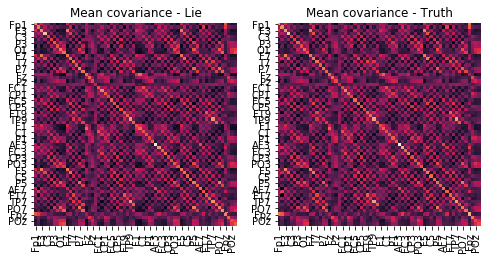

In [54]:
mdm = MDM()
mdm.fit(cov_data_train, labels)

fig, axes = plt.subplots(1, 2, figsize=[8, 4])
ch_names = [ch.replace('.', '') for ch in epochs.ch_names]

df = pd.DataFrame(data=mdm.covmeans_[0], index=ch_names, columns=ch_names)
g = sns.heatmap(df, ax=axes[0], square=True, cbar=False, xticklabels=2,
                yticklabels=2)
g.set_title('Mean covariance - Lie')

df = pd.DataFrame(data=mdm.covmeans_[1], index=ch_names, columns=ch_names)
g = sns.heatmap(df, ax=axes[1], square=True, cbar=False, xticklabels=2,
                yticklabels=2)
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
g.set_title('Mean covariance - Truth')

# dirty fix
plt.sca(axes[0])
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
plt.show()